In [1]:
import os, glob
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from matplotlib.widgets import RangeSlider

In [2]:
import pyFAI

In [3]:
%matplotlib widget

In [4]:
import importlib
color_tuner = importlib.import_module("color_tuner")
importlib.reload(color_tuner)

<module 'color_tuner' from '/Users/cheng-hunglin/Documents/Git_2025_MAC/Data_process/20250808_PDF/color_tuner.py'>

## Find all XRD data folders

In [5]:
data_dir = '/Users/cheng-hunglin/Documents/Data_LDRD/user_data_Bai_316861_1a802ea0_2025-08-08-0910/tiff_base/LDRD_chl/'
XRD_folders = os.path.join(data_dir, '**XRD**')
XRD_list = glob.glob(XRD_folders)
XRD_list.sort()
print(*[os.path.basename(n) for n in XRD_list], sep='\n')

Cs4PbBr6_No3_XRD
Cs4PbI6_No1_XRD
CsBr_No2_XRD
CsPbBr3_No4_XRD
Ni_chl_XRD
Toluene_quartz_XRD
empty_quartz_XRD


## Average all tiffs in each XRD data folder

In [6]:
for sn in XRD_list:   #sn: sample_name
    sn_tiff_list = glob.glob(os.path.join(sn, 'dark_sub', '**.tiff'))
    x, y = io.imread(sn_tiff_list[0]).shape
    z = len(sn_tiff_list)
    img0 = np.zeros([z, x, y], dtype=np.float32)
    for i in range(len(sn_tiff_list)):
        img = io.imread(sn_tiff_list[i])
        img0[i] = img
    tiff_basename = os.path.basename(sn_tiff_list[i])
    fn_prefix = tiff_basename[:tiff_basename.index('20250807')+len('20250807')]
    sum_tiff_fn = os.path.join(sn, 'average', f'{fn_prefix}_mean.tiff')
    os.makedirs(os.path.dirname(sum_tiff_fn), exist_ok=True)
    io.imsave(sum_tiff_fn, img0.mean(axis=0, dtype=np.float32))
    

In [7]:
sum_tiff_fn

'/Users/cheng-hunglin/Documents/Data_LDRD/user_data_Bai_316861_1a802ea0_2025-08-08-0910/tiff_base/LDRD_chl/empty_quartz_XRD/average/empty_quartz_XRD_20250807_mean.tiff'

## Plot an average tiff and add interactive range slider for color range 

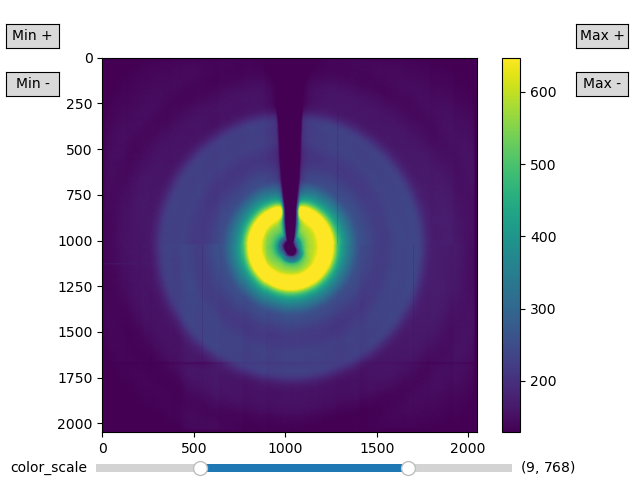

In [8]:
fig = plt.figure()
img = io.imread(sum_tiff_fn)
img_tuner = color_tuner.color_tuner(fig, img)
img_tuner()


## Load poni, mask by pyFai and execute percentile integration

In [9]:
config_dir = '/Users/cheng-hunglin/Documents/Data_LDRD/user_data_Bai_316861_1a802ea0_2025-08-08-0910/config_base/'
poni_fn = os.path.join(config_dir, 'pe1c_XRD_chl', 'xpdAcq_calib_info.poni')
mask_fn = os.path.join(config_dir, 'pe1c_XRD_MA', 'Mask.npy')

In [10]:
ai = pyFAI.load(poni_fn)

In [11]:
mask0 = np.load(mask_fn)

In [12]:
npt_rad = 4096
npt_azim = 360*10
polarization = 0.99
UNIT = 'q_A^-1'
low_limit_pcfilter = 1
up_limit_pcfilter = 99


In [13]:
def iq_saver(fn, df, md, header=['q_A^-1', 'I(q)']):
    
    os.makedirs(os.path.dirname(fn), exist_ok=True)
    
    with open(fn, mode='w+', encoding='utf-8') as f:
        f.write('pyFai_poni_information_28ID1_NSLS2_BNL\n')
        num_row = 1
        for key, value in md.items():
            f.write(f'{key} {value}\n')
            num_row += 1
    
    ## Now append the dataframe
    df.to_csv(fn, encoding='utf-8', mode='a', header=header, index=False, float_format='{:.8e}'.format, sep=' ')

    ## return the number of rows of the header
    # return num_row

In [14]:
def pct_integration(img_array, iq_fn, save=True):

    ## perform azimuthalintegration on one image to retain 2D information
    ## i2d.shape is (self.npt_azim, self.npt_rad) which corresponds the intensity of 2D image cake
    ## q1d.shape is (self.npt_rad, )
    i2d, q1d, chi1d = ai.integrate2d(img, npt_rad, 
                                     unit=UNIT, npt_azim=npt_azim, 
                                     polarization_factor=polarization, 
                                     method=('bbox', 'csr', 'cython'), 
                                     mask=mask0)
    
    ## trasnform mask0 (base mask) to the same coordinate space and cast it as type bool
    intrinsic_mask_unrolled, _, _ = ai.integrate2d(mask0, npt_rad, 
                                                   unit=UNIT, npt_azim=npt_azim, 
                                                   polarization_factor=polarization, 
                                                   mask=mask0)
    
    ## Create an array to hold outlier mask
    outlier_mask_2d = np.zeros_like(i2d)     
    mask1 = np.array(i2d<1)*1
    
    ## Apply percentile filter along radial direction (axis=0)
    for ii, dd in enumerate(i2d.T):
        low_limit, high_limit = np.percentile(dd, (low_limit_pcfilter, up_limit_pcfilter))
        outlier_mask_2d[:,ii] = np.any([dd<low_limit, dd>high_limit, intrinsic_mask_unrolled[:,ii]], axis=0)
    
    mask2 = outlier_mask_2d + mask1
    outlier_mask_2d_masked = ma.masked_array(i2d, mask=mask2)
    
    ## calculate mean values along radial direction (axis=0) to make i1d.shape is (self.npt_rad, )
    i1d = ma.mean(outlier_mask_2d_masked, axis=0)
    
    
    iq_df0 = pd.DataFrame()
    iq_df0['q'] = q1d
    iq_df0['I'] = i1d
    iq_df = iq_df0.dropna()

    if save:
        md = ai.getPyFAI()
        iq_saver(iq_fn, iq_df, md)
        print(f'\n*** {os.path.basename(iq_fn)} saved!! ***\n')

    return iq_df0, i2d, outlier_mask_2d_masked

In [15]:
for sn in XRD_list:   #sn: sample_name
    sn_tiff_list = glob.glob(os.path.join(sn, 'average', '**mean.tiff'))
    for i in range(len(sn_tiff_list)):
        img = io.imread(sn_tiff_list[i])
        iq_basename = os.path.basename(sn_tiff_list[i]).split('.')[0]
        iq_fn = os.path.join(sn, 'average', iq_basename+'.iq')
        iq_df, i2d, outlier_mask_2d_masked = pct_integration(img, iq_fn)


*** Cs4PbBr6_No3_XRD_20250807_mean.iq saved!! ***


*** Cs4PbI6_No1_XRD_20250807_mean.iq saved!! ***


*** CsBr_No2_XRD_20250807_mean.iq saved!! ***


*** CsPbBr3_No4_XRD_20250807_mean.iq saved!! ***


*** Ni_chl_XRD_20250807_mean.iq saved!! ***


*** Toluene_quartz_XRD_20250807_mean.iq saved!! ***


*** empty_quartz_XRD_20250807_mean.iq saved!! ***



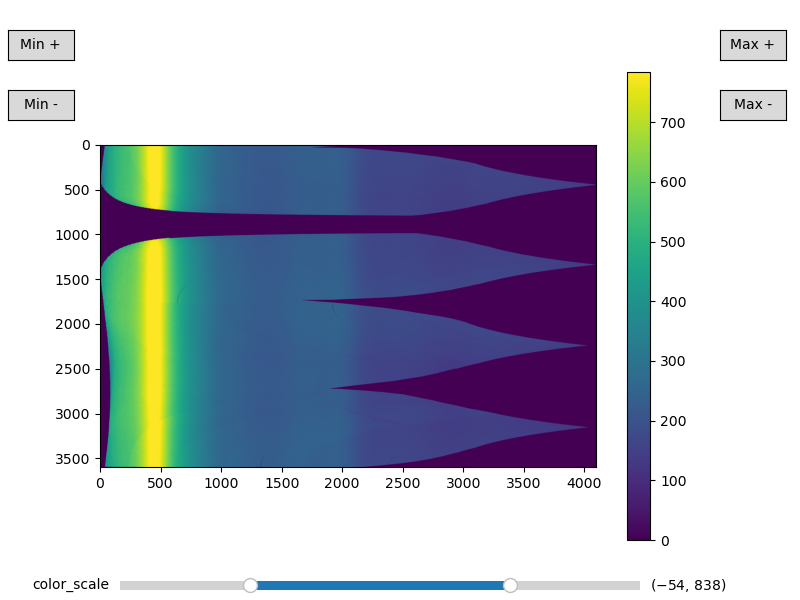

In [16]:
fig = plt.figure(figsize=(8, 6))
img_tuner = color_tuner.color_tuner(fig, i2d, aspect=0.65*npt_rad/npt_azim)
img_tuner()

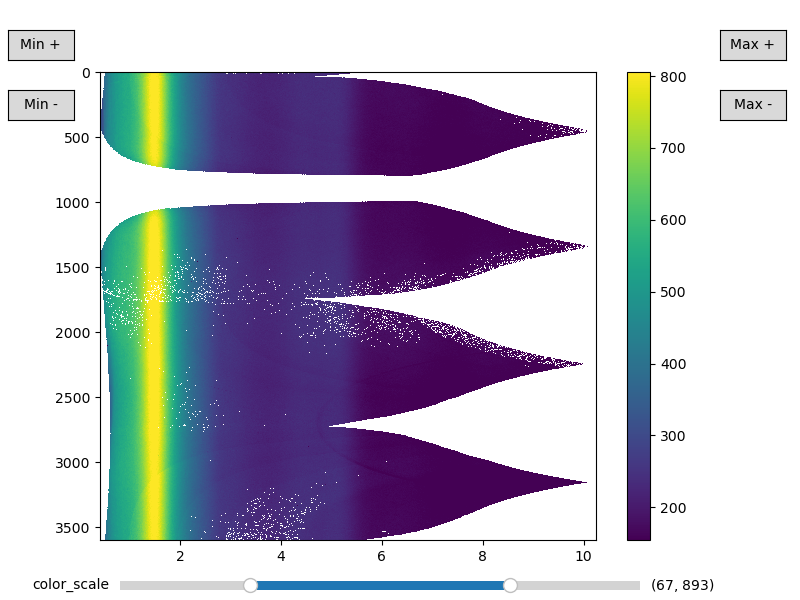

In [17]:
fig = plt.figure(figsize=(8, 6))
i2d_m = outlier_mask_2d_masked.filled(fill_value=np.nan)
img_tuner = color_tuner.color_tuner(fig, i2d_m, q_array = iq_df['q'])
img_tuner()